In [24]:
import os
import shutil

def organize_braTS_data(src_root="./data", dst_root="./dataset"):
    """
    Extract ./TumorSegmentationData to data and label form
    """
    os.makedirs(os.path.join(dst_root, "data"), exist_ok=True)
    os.makedirs(os.path.join(dst_root, "label"), exist_ok=True)
    
    for folder in sorted(os.listdir(src_root)):
        folder_path = os.path.join(src_root, folder)
        if os.path.isdir(folder_path):
            case_number = folder.split("_")[-1]  # Extracting case number
            
            for file in os.listdir(folder_path):
                src_file = os.path.join(folder_path, file)
                if file.endswith("_t1.nii"):
                    dst_file = os.path.join(dst_root, "data", f"data_{case_number}_t1.nii")
                    shutil.move(src_file, dst_file)
                elif file.endswith("_seg.nii"):
                    dst_file = os.path.join(dst_root, "label", f"label_{case_number}.nii")
                    shutil.move(src_file, dst_file)

if __name__ == "__main__":
    organize_braTS_data()

In [25]:
import os
import nibabel as nib
import numpy as np
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

In [26]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA!")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU!")
EPOCHS = 100
TRAIN_SPLIT = 0.8
LR = 2e-3
STEP_SIZE = 3
GAMMA = 0.1
MANUAL_SEED = 42
BATCH_SIZE = 16
TARGET_SIZE = 32

Using CUDA!


In [27]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    """
    모든 관련 라이브러리의 랜덤 시드를 고정합니다.
    
    Args:
        seed (int): 고정할 랜덤 시드 값
    """
    # Python 내장 랜덤 시드 고정
    random.seed(seed)
    
    # NumPy 랜덤 시드 고정
    np.random.seed(seed)
    
    # PyTorch 랜덤 시드 고정
    torch.manual_seed(seed)  # CPU에서 PyTorch 랜덤 시드 고정
    torch.cuda.manual_seed(seed)  # GPU에서 PyTorch 랜덤 시드 고정 (CUDA 장치)
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 PyTorch 랜덤 시드 고정
    
    # CuDNN 관련 설정
    torch.backends.cudnn.deterministic = True  # 결정적 알고리즘을 사용하여 결과 고정
    torch.backends.cudnn.benchmark = False  # 벤치마크 모드를 비활성화하여 성능 최적화 방지

# 시드 고정 예시
set_random_seed(MANUAL_SEED)

In [28]:
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min_val = -1000
    max_val = 400
    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val
    volume = (volume - min_val) / (max_val - min_val)
    volume = volume.astype("float32")
    return volume


def resize(image, target_size):
    """이미지 크기 조정 (PIL 없이 numpy 기반)"""
    if image.ndim == 2:
        # 흑백 이미지 (H, W) 크기 조정
        return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)
    elif image.ndim == 3:
        # 컬러 이미지 (H, W, C) 크기 조정
        zoom_factors = (target_size[0] / image.shape[0], target_size[1] / image.shape[1])
        resized = np.stack([scipy.ndimage.zoom(image[..., i], zoom_factors, order=1) for i in range(image.shape[2])], axis=-1)
        return resized
    else:
        raise ValueError("Unsupported image dimensions")

            
def resize_volume(img):
    """Resize to 64x64x64"""
    desired_depth = TARGET_SIZE
    desired_width = TARGET_SIZE
    desired_height = TARGET_SIZE
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [29]:
import os

# 경로 설정 (현재 작업 디렉토리 기준)
data_dir = './dataset/label'

# 숫자 001부터 369까지 파일이 있는지 확인 (_001, _002, ...)
expected_files = [f"label_{str(i)}.nii" for i in range(1, 25)]
print(expected_files)
# 실제 파일 목록 가져오기
try:
    actual_files = sorted(os.listdir(data_dir))
    # 실제 파일 목록에 있는지 확인
    missing_files = [file for file in expected_files if file not in actual_files]

    if missing_files:
        print("Missing files:", missing_files)
    else:
        print("All expected files are present.")
except FileNotFoundError:
    print(f"The directory {data_dir} does not exist.")


['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']
Missing files: ['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']


In [30]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_paths = sorted([f for f in os.listdir(data_dir) if f.endswith('.nii')])
        self.label_paths = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii')])
        self.data_dir = data_dir
        self.label_dir = label_dir

        # 데이터와 라벨의 개수가 일치하는지 확인
        assert len(self.data_paths) == len(self.label_paths), \
            f"Mismatch between data and label files: {len(self.data_paths)} | {len(self.label_paths)}"
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.data_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])
        
        data = read_nifti_file(data_path)
        label = read_nifti_file(label_path)     

        # 최소, 최대 값 계산
        # min_val = np.min(data)
        # max_val = np.max(data)
        # print(min_val, max_val)
        data = normalize(data)
        data = resize_volume(data)
        label = resize_volume(label)

        # Convert numpy to torch tensor
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)     # Add channel dimension
        label = torch.tensor(label, dtype=torch.long)                   # For segmentation tasks, long type is needed for one-hot encoding
    
        # One-hot encoding: (64, 64, 64) -> (64, 64, 64, 5) -> (5, 64, 64, 64)
        # label_one_hot = F.one_hot(label, num_classes=5).permute(3, 0, 1, 2).float()
        label_one_hot = label
        return data, label_one_hot


In [31]:
dataset = BraTSDataset("./dataset/data", "./dataset/label")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

data shape:  torch.Size([1, 32, 32, 32]) <class 'torch.Tensor'>
label shape:  torch.Size([32, 32, 32]) <class 'torch.Tensor'>
(32, 32, 32)
torch.Size([32, 32, 32])


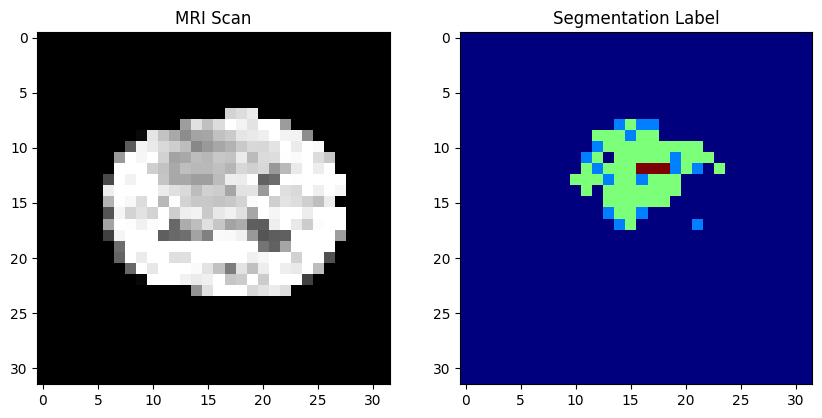

In [32]:
def visualize_sample(dataset, idx=0):
    """Visualize a single sample from the dataset"""
    data, label = dataset[idx]
    print("data shape: ", data.shape, type(data))
    print("label shape: ", label.shape, type(label))
    
    data = data.squeeze().numpy()
    # label = torch.argmax(label, dim=0)
    
    print(data.shape)
    print(label.shape)
    slice_idx = data.shape[-1] // 2  # Select middle slice
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[:, :, slice_idx], cmap='gray')
    axes[0].set_title("MRI Scan")
    
    axes[1].imshow(label[:, :, slice_idx], cmap='jet')
    axes[1].set_title("Segmentation Label")
    
    plt.show()

visualize_sample(dataset, idx=0)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """ (Conv3D -> BN -> ReLU) * 2 """
    def __init__(self, in_channels, mid_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    """ (Conv3D -> ReLU) * 2 """
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.upconv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=32):
        super(UNet3D, self).__init__()

        self.encoder1 = DoubleConv(in_channels, base_channels, base_channels * 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder2 = DoubleConv(base_channels * 2, base_channels * 2, base_channels * 4)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder3 = DoubleConv(base_channels * 4, base_channels * 4, base_channels * 8)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder4 = DoubleConv(base_channels * 8, base_channels * 8, base_channels * 16)

        self.upconv3 = UpConv(base_channels * 16, base_channels * 16)
        self.decoder3 = DoubleConv(base_channels * 24, base_channels * 8, base_channels * 8)

        self.upconv2 = UpConv(base_channels * 8, base_channels * 8)
        self.decoder2 = DoubleConv(base_channels * 12, base_channels * 4, base_channels * 4)

        self.upconv1 = UpConv(base_channels * 4, base_channels * 4)
        self.decoder1 = DoubleConv(base_channels * 6, base_channels * 2, base_channels * 2)

        self.outconv = nn.Conv3d(base_channels * 2, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        dec3 = self.upconv3(enc4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.outconv(dec1)

        return out

In [34]:
model = UNet3D(in_channels=1, out_channels=5) # Tumor 1,2,3,4 | 배경
x = torch.randn(1, 1, 64, 64, 64)  # Example 3D volume
output = model(x)
print(output.shape)

torch.Size([1, 5, 64, 64, 64])


In [35]:
import torch
torch.cuda.empty_cache()

In [36]:
from collections import Counter
import numpy as np

# 데이터셋에서 클래스별 샘플 개수 계산
labels = []  # 전체 데이터셋에서 라벨을 수집해야 함

for _, label in train_loader:
    # label = torch.argmax(label, dim=1)  # 원-핫 벡터를 클래스 인덱스로 변환
    labels.extend(label.cpu().numpy().flatten())  # numpy 배열로 변환 후 리스트에 추가

# 클래스별 샘플 개수 계산
class_counts = Counter(labels)
total_samples = sum(class_counts.values())

# 가중치 계산: 총 샘플 수 / (클래스별 샘플 수 * 클래스 개수)
class_weights = {cls: total_samples / (count * len(class_counts)) for cls, count in class_counts.items()}
class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float).to(DEVICE)

print("Class Weights:", class_weights)

Class Weights: tensor([2.0202e-01, 5.1284e+01, 4.6823e+01, 2.7771e+02, 1.7859e+02],
       device='cuda:0')


In [37]:
import os

#현재 폴더 경로; 작업 폴더 기준
print(os.getcwd())

/home/jjpark/SKKAI/3D-Tumor-Segmentation


Epoch 1/100:   0%|          | 0/15 [00:00<?, ?it/s]

Validation 1/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9815, loss=645]


Epoch 1/100 - Train Loss: 1.5141, Train Acc: 0.5038, Val Loss: 556.8293, Val Acc: 0.9833
✓ Saved new best model with validation loss: 556.8293


Validation 2/100: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, acc=0.8788, loss=6.31]


Epoch 2/100 - Train Loss: 1.3364, Train Acc: 0.7955, Val Loss: 4.9701, Val Acc: 0.8842
✓ Saved new best model with validation loss: 4.9701


Validation 3/100: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, acc=0.8384, loss=1.47]


Epoch 3/100 - Train Loss: 1.3000, Train Acc: 0.8179, Val Loss: 1.3905, Val Acc: 0.8407
✓ Saved new best model with validation loss: 1.3905


Validation 4/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.8395, loss=1.31]


Epoch 4/100 - Train Loss: 1.2743, Train Acc: 0.8371, Val Loss: 1.2868, Val Acc: 0.8408
✓ Saved new best model with validation loss: 1.2868


Validation 5/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.8410, loss=1.3] 


Epoch 5/100 - Train Loss: 1.2685, Train Acc: 0.8349, Val Loss: 1.2749, Val Acc: 0.8432
✓ Saved new best model with validation loss: 1.2749


Validation 6/100: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, acc=0.8490, loss=1.3] 


Epoch 6/100 - Train Loss: 1.2667, Train Acc: 0.8368, Val Loss: 1.2702, Val Acc: 0.8508
✓ Saved new best model with validation loss: 1.2702


Validation 7/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.8416, loss=1.3] 


Epoch 7/100 - Train Loss: 1.2639, Train Acc: 0.8391, Val Loss: 1.2735, Val Acc: 0.8439
Early stopping counter: 1/10


Validation 8/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.8386, loss=1.3] 


Epoch 8/100 - Train Loss: 1.2647, Train Acc: 0.8390, Val Loss: 1.2752, Val Acc: 0.8412
Early stopping counter: 2/10


Validation 9/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.8380, loss=1.3] 


Epoch 9/100 - Train Loss: 1.2636, Train Acc: 0.8389, Val Loss: 1.2753, Val Acc: 0.8407
Early stopping counter: 3/10


Validation 10/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.8365, loss=1.3] 


Epoch 10/100 - Train Loss: 1.2610, Train Acc: 0.8394, Val Loss: 1.2767, Val Acc: 0.8392
Early stopping counter: 4/10


Validation 11/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.8368, loss=1.3] 


Epoch 11/100 - Train Loss: 1.2630, Train Acc: 0.8392, Val Loss: 1.2768, Val Acc: 0.8394
Early stopping counter: 5/10


Validation 12/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.8366, loss=1.3] 


Epoch 12/100 - Train Loss: 1.2627, Train Acc: 0.8394, Val Loss: 1.2769, Val Acc: 0.8393
Early stopping counter: 6/10


Validation 13/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.8360, loss=1.3] 


Epoch 13/100 - Train Loss: 1.2624, Train Acc: 0.8394, Val Loss: 1.2772, Val Acc: 0.8387
Early stopping counter: 7/10


Validation 14/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.8361, loss=1.3] 


Epoch 14/100 - Train Loss: 1.2637, Train Acc: 0.8393, Val Loss: 1.2772, Val Acc: 0.8388
Early stopping counter: 8/10


Validation 15/100: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, acc=0.8362, loss=1.3] 


Epoch 15/100 - Train Loss: 1.2620, Train Acc: 0.8394, Val Loss: 1.2772, Val Acc: 0.8389
Early stopping counter: 9/10


Validation 16/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.8360, loss=1.3] 


Epoch 16/100 - Train Loss: 1.2633, Train Acc: 0.8395, Val Loss: 1.2772, Val Acc: 0.8387
Early stopping counter: 10/10
Early stopping triggered
Early stopping triggered after 16 epochs

Training completed! Best validation loss: 1.2702


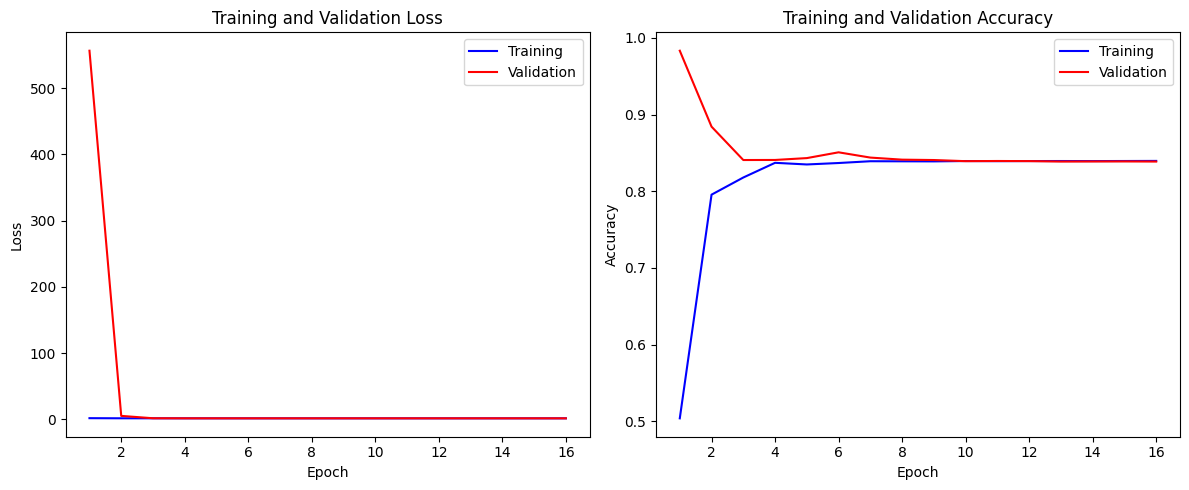

Loading best model for visualization...


/tmp/ipykernel_2452238/3550283033.py:204: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/3DUNet_best.pth'))


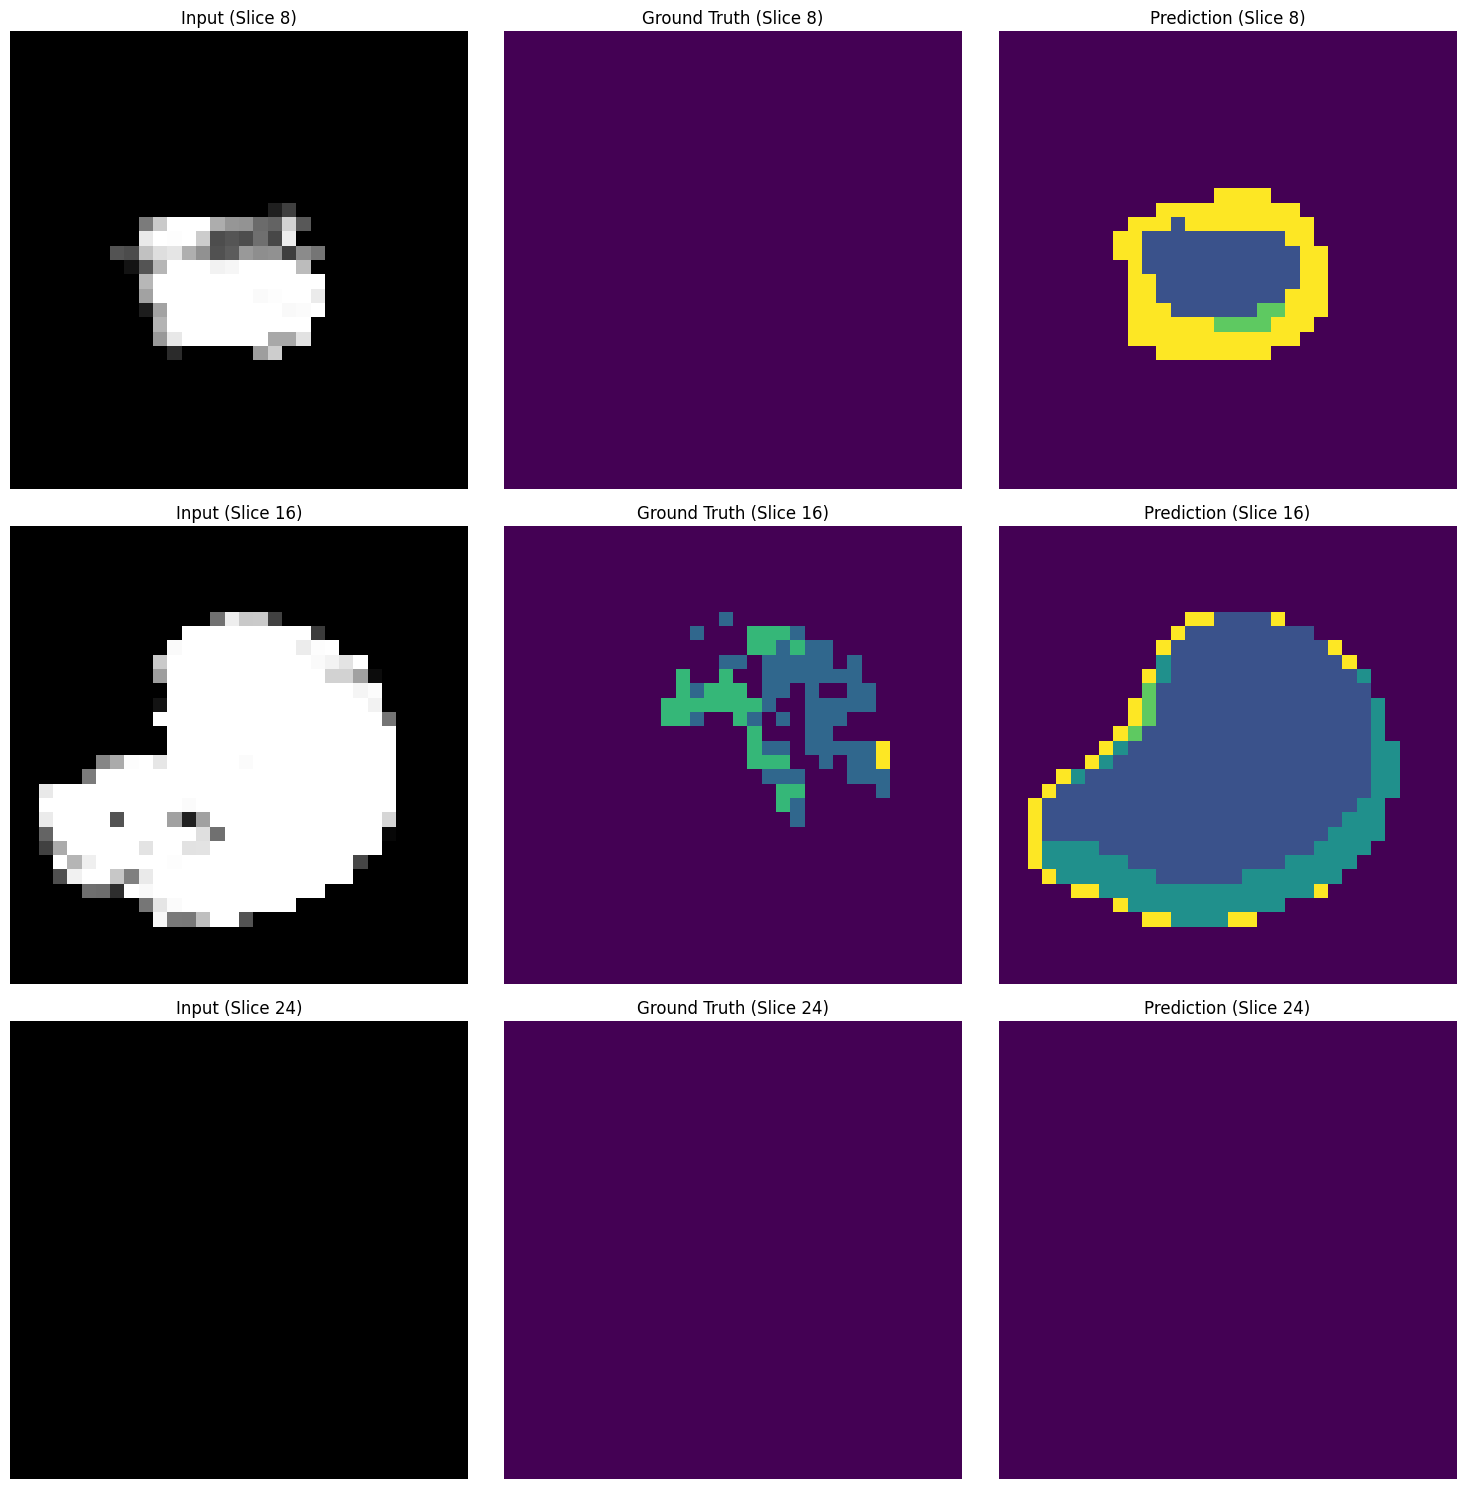

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader

# Create directories if they don't exist
os.makedirs('./model', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# ========== 1. DICE LOSS IMPLEMENTATION ==========
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, ignore_background=True):
        """
        Dice Loss for segmentation tasks
        
        Args:
            smooth (float): Smoothing value to avoid division by zero
            ignore_background (bool): Whether to ignore background class (index 0)
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_background = ignore_background
        
    def forward(self, inputs, targets):
        """
        Calculate Dice Loss
        
        Args:
            inputs: Model predictions (B, C, D, H, W)
            targets: Ground truth labels (B, D, H, W)
            
        Returns:
            Loss value
        """
        # Get softmax probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # Convert targets to one-hot encoding
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        
        # Flatten the spatial dimensions
        inputs = inputs.reshape(inputs.size(0), inputs.size(1), -1)
        targets_one_hot = targets_one_hot.reshape(targets_one_hot.size(0), targets_one_hot.size(1), -1)
        
        # Calculate Dice coefficient for each class and batch
        dice_scores = []
        
        # Loop through classes
        start_idx = 1 if self.ignore_background else 0
        
        for cls in range(start_idx, num_classes):
            # Get current class predictions and targets
            input_cls = inputs[:, cls, :]  # (B, D*H*W)
            target_cls = targets_one_hot[:, cls, :]  # (B, D*H*W)
            
            # Calculate intersection and union
            intersection = (input_cls * target_cls).sum(dim=1)  # (B)
            sum_inputs = input_cls.sum(dim=1)  # (B)
            sum_targets = target_cls.sum(dim=1)  # (B)
            
            # Dice coefficient
            dice = (2.0 * intersection + self.smooth) / (sum_inputs + sum_targets + self.smooth)  # (B)
            
            # Skip empty target slices (for stability)
            non_empty = sum_targets > 0
            if non_empty.sum() > 0:
                dice_valid = dice[non_empty]
                dice_scores.append(dice_valid.mean())
        
        # Check if we have any valid dice scores
        if len(dice_scores) == 0:
            # If no valid scores (e.g., all background), return a loss value
            # that encourages the model to predict background
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        
        # Average Dice score
        dice_avg = torch.stack(dice_scores).mean()
        
        # Return Dice loss (1 - Dice coefficient)
        return 1.0 - dice_avg

# ========== 2. DICE METRIC CALCULATION ==========
def calculate_dice_coefficient(outputs, targets, ignore_background=True):
    """
    Calculate Dice coefficient for evaluation
    
    Args:
        outputs: Model outputs (B, C, D, H, W)
        targets: Ground truth labels (B, D, H, W)
        ignore_background: Whether to ignore background class (index 0)
        
    Returns:
        Dice coefficient
    """
    # Get predicted class
    _, predicted = torch.max(outputs, 1)  # (B, D, H, W)
    
    # Get number of classes
    num_classes = outputs.size(1)
    
    # Calculate Dice for each class
    dice_scores = []
    
    # Loop through classes
    start_idx = 1 if ignore_background else 0
    
    for cls in range(start_idx, num_classes):
        # Create binary masks for this class
        pred_mask = (predicted == cls).float()  # (B, D, H, W)
        true_mask = (targets == cls).float()    # (B, D, H, W)
        
        # Skip if no ground truth for this class
        if true_mask.sum() == 0:
            continue
            
        # Calculate intersection and union
        intersection = (pred_mask * true_mask).sum()
        union = pred_mask.sum() + true_mask.sum()
        
        # Dice coefficient
        dice = (2.0 * intersection + 1.0) / (union + 1.0)
        dice_scores.append(dice.item())
    
    # Return mean Dice coefficient
    if len(dice_scores) > 0:
        return sum(dice_scores) / len(dice_scores)
    else:
        return 1.0  # Perfect dice if no foreground classes (all background)

# ========== 3. EARLY STOPPING ==========
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, verbose=True):
        """
        Early stopping to stop training when validation loss doesn't improve.
        
        Args:
            patience (int): Number of epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints a message when early stopping triggers
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        """
        Check if training should be stopped.
        
        Args:
            val_loss (float): Current validation loss
            
        Returns:
            bool: True if training should stop, False otherwise
        """
        if val_loss < self.best_loss - self.min_delta:
            # Validation loss has improved
            self.best_loss = val_loss
            self.counter = 0
        else:
            # Validation loss has not improved
            self.counter += 1
            if self.verbose:
                print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')
        
        return self.early_stop

# ========== 4. DATASET SETUP ==========
dataset_size = len(train_dataset)
val_size = int(dataset_size * 0.2)  
train_size = dataset_size - val_size

train_subset, val_subset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42) 
)

train_loader = DataLoader(
    train_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS if 'NUM_WORKERS' in globals() else 4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS if 'NUM_WORKERS' in globals() else 4
)

# ========== 5. TRAINING SETUP ==========
model.to(DEVICE)

# Use Dice Loss instead of CrossEntropyLoss
criterion = DiceLoss(smooth=1.0, ignore_background=True)

# Lower learning rate for stability with Dice Loss
LR_DICE = LR * 0.5  # Half the original learning rate for stability

optimizer = optim.Adam(model.parameters(), lr=LR_DICE)

# Use ReduceLROnPlateau instead of StepLR for better adaptation
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

# Initialize tracking variables
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_dices = []
val_dices = []
lr_history = []

# Initialize early stopping
early_stopping = EarlyStopping(patience=15, min_delta=0.001, verbose=True)

# ========== 6. UTILITY FUNCTIONS ==========
def calculate_accuracy(outputs, labels):
    """Calculate pixel-wise accuracy"""
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.numel()
    return correct / total

# ========== 7. TRAINING LOOP ==========
print(f"Starting training with: Learning Rate={LR_DICE}, Batch Size={BATCH_SIZE}")
print(f"Using Dice Loss (ignore_background={criterion.ignore_background})")
print(f"Early stopping patience: {early_stopping.patience}")

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0
    train_dice = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for data, label in progress_bar:
        data, label = data.to(DEVICE), label.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, label)
        
        # Handle NaN loss
        if torch.isnan(loss):
            print(f"Warning: NaN loss encountered. Skipping batch.")
            continue
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Calculate metrics
        acc = calculate_accuracy(output, label)
        dice = 1.0 - loss.item()  # Dice score = 1 - Dice loss
        
        # Update progress bar
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}", dice=f"{dice:.4f}")
        
        # Update running metrics
        train_loss += loss.item()
        train_acc += acc
        train_dice += dice
    
    # Calculate average training metrics
    samples = len(train_loader)
    train_loss = train_loss / samples
    train_acc = train_acc / samples
    train_dice = train_dice / samples
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_dices.append(train_dice)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    val_dice = 0
    
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Validation {epoch+1}/{EPOCHS}")
        for data, label in val_progress_bar:
            data, label = data.to(DEVICE), label.to(DEVICE)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, label)
            
            # Handle NaN loss
            if torch.isnan(loss):
                print(f"Warning: NaN validation loss. Skipping batch.")
                continue
            
            # Calculate metrics
            acc = calculate_accuracy(output, label)
            dice = 1.0 - loss.item()  # Dice score = 1 - Dice loss
            
            # Update progress bar
            val_progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}", dice=f"{dice:.4f}")
            
            # Update running metrics
            val_loss += loss.item()
            val_acc += acc
            val_dice += dice
    
    # Calculate average validation metrics
    val_samples = len(val_loader)
    val_loss = val_loss / val_samples
    val_acc = val_acc / val_samples
    val_dice = val_dice / val_samples
    
    # Store metrics for plotting
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_dices.append(val_dice)
    
    # Store current learning rate
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Dice: {train_dice:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Dice: {val_dice:.4f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Save model if it's the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_dice': val_dice,
        }, './model/3DUNet_best.pth')
        print(f"✓ Saved new best model with validation loss: {best_val_loss:.4f} (Dice: {val_dice:.4f})")
    
    # Early stopping check
    if early_stopping(val_loss):
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

# ========== 8. VISUALIZATION ==========
# Plot training and validation metrics for actual epochs trained
epochs_trained = len(train_losses)
plt.figure(figsize=(15, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs_trained+1), train_losses, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_losses, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (1 - Dice)')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs_trained+1), train_accs, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_accs, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Dice score
plt.subplot(2, 2, 3)
plt.plot(range(1, epochs_trained+1), train_dices, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_dices, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()

# Plot learning rate
plt.subplot(2, 2, 4)
plt.plot(range(1, epochs_trained+1), lr_history, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.savefig('./results/training_curves.png', dpi=300)
plt.show()

# ========== 9. MODEL EVALUATION AND VISUALIZATION ==========
print("Loading best model for visualization...")
checkpoint = torch.load('./model/3DUNet_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with Dice score: {1.0 - checkpoint['val_loss']:.4f}")
model.eval()

sample_data, sample_label = next(iter(val_loader))
sample_data, sample_label = sample_data.to(DEVICE), sample_label.to(DEVICE)

with torch.no_grad():
    sample_output = model(sample_data)
    _, predicted = torch.max(sample_output, 1)

def visualize_3d_predictions(sample_idx=0, num_slices=3):
    """
    Visualize predictions on a 3D volume with class information
    """
    input_vol = sample_data[sample_idx, 0].cpu().numpy()  
    label_vol = sample_label[sample_idx].cpu().numpy()
    pred_vol = predicted[sample_idx].cpu().numpy()
    
    # Get dimensions
    d, h, w = input_vol.shape
    
    # Find slices with foreground (non-zero) labels if possible
    foreground_slices = []
    for z in range(d):
        if np.any(label_vol[z] > 0):
            foreground_slices.append(z)
    
    # Choose slices - prefer those with foreground classes
    if len(foreground_slices) >= num_slices:
        # Select evenly spaced foreground slices
        indices = np.linspace(0, len(foreground_slices)-1, num_slices, dtype=int)
        z_indices = [foreground_slices[i] for i in indices]
    else:
        # Fallback to evenly spaced slices
        z_indices = np.linspace(d//4, 3*d//4, num_slices, dtype=int)
    
    # Get unique classes for better visualization
    all_classes = sorted(np.unique(np.concatenate((label_vol.flatten(), pred_vol.flatten()))))
    num_classes = len(all_classes)
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_slices, 3, figsize=(15, 5*num_slices))
    
    if num_slices == 1:
        axes = axes.reshape(1, -1)
    
    # Use viridis colormap for multiple classes
    cmap = plt.cm.viridis
    
    for i, z in enumerate(z_indices):
        # Input slice - grayscale
        axes[i, 0].imshow(input_vol[z], cmap='gray')
        axes[i, 0].set_title(f'Input (Slice {z})')
        axes[i, 0].axis('off')
        
        # Ground truth slice - with colormap
        im1 = axes[i, 1].imshow(label_vol[z], cmap=cmap, vmin=0, vmax=max(1, num_classes-1))
        axes[i, 1].set_title(f'Ground Truth (Slice {z})')
        axes[i, 1].axis('off')
        
        # Prediction slice - with same colormap
        im2 = axes[i, 2].imshow(pred_vol[z], cmap=cmap, vmin=0, vmax=max(1, num_classes-1))
        axes[i, 2].set_title(f'Prediction (Slice {z})')
        axes[i, 2].axis('off')
    
    # Add colorbar if we have multiple classes
    if num_classes > 1:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(im2, cax=cbar_ax)
        cbar.set_ticks(range(num_classes))
        cbar.set_ticklabels([f"Class {c}" for c in all_classes])
    
    plt.tight_layout()
    plt.savefig('./results/3d_prediction_results.png', dpi=300)
    plt.show()

# Visualize multiple samples
for i in range(min(2, sample_data.size(0))):
    print(f"Visualizing sample {i+1}")
    visualize_3d_predictions(sample_idx=i, num_slices=3)

# ========== 10. OPTIONAL: PER-CLASS EVALUATION ==========
def evaluate_per_class_metrics(model, loader, num_classes, device):
    """Evaluate Dice score for each class separately"""
    model.eval()
    class_dices = [[] for _ in range(num_classes)]
    
    with torch.no_grad():
        for data, label in tqdm(loader, desc="Evaluating per-class metrics"):
            data, label = data.to(device), label.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            
            # Calculate per-class Dice
            for cls in range(num_classes):
                # Skip if this class doesn't exist in the ground truth
                if torch.sum(label == cls) == 0:
                    continue
                
                pred_mask = (pred == cls).float()
                true_mask = (label == cls).float()
                
                intersection = (pred_mask * true_mask).sum()
                union = pred_mask.sum() + true_mask.sum()
                
                # Calculate Dice
                dice = (2.0 * intersection + 1.0) / (union + 1.0)
                class_dices[cls].append(dice.item())
    
    # Print per-class results
    print("\nPer-class Dice scores:")
    for cls in range(num_classes):
        if class_dices[cls]:
            mean_dice = sum(class_dices[cls]) / len(class_dices[cls])
            print(f"Class {cls}: {mean_dice:.4f} (from {len(class_dices[cls])} samples)")
        else:
            print(f"Class {cls}: No samples")
    
    return class_dices

# Uncomment to evaluate per-class metrics
# num_classes = sample_output.size(1)  # Number of output channels
# evaluate_per_class_metrics(model, val_loader, num_classes, DEVICE)

In [39]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import sys
import nibabel as nib

def save_as_nifti(tensor, filename):
    """
    Save a tensor as a NIfTI file.
    tensor: Tensor to be saved as NIfTI.
    filename: The output file name.
    """
    # Convert tensor to numpy array (NIfTI requires numpy arrays)
    nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4))  # Using identity matrix as affine
    
    # Save as NIfTI file
    nib.save(nifti_img, filename)

def multiclass_dice_coeff(input, target, epsilon=1e-6):
    """
    Compute the Dice Score for multi-class segmentation.
    
    Args:
        input (torch.Tensor): Model output logits (C, H, W, D).
        target (torch.Tensor): Ground truth labels (C, H, W, D).
        epsilon (float): Small value to avoid division by zero.
        
    Returns:
        mean_dice (float): Mean Dice Score across all classes.
    """
    input = torch.argmax(input, dim=0)  # (H, W, D) - get class index with highest logit
    
    # Ensure target is long type
    target = target.int()
    
    # Calculate intersection and union
    intersection = (input * target).sum()
    union = input.sum() + target.sum()

    # Compute Dice score
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

# Test loop
save = False
total_dice = 0
total_samples = 0

model.to(DEVICE)
model.eval()
total_loss = 0
criterion = nn.CrossEntropyLoss(weight=class_weights)

with torch.no_grad():
    for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
        data, label = data.to(DEVICE), label.to(DEVICE)
        
        data_clone = data.clone()
        label_clone = label.clone()

        # Check data dimensions before operations
        print(f"Original data shape: {data.shape}")
        print(f"Original label shape: {label.shape}")
        
        # Model forward pass
        output = model(data)  # Output shape should be (batch, C, D, H, W)
        print(f"Model output shape: {output.shape}")
        
        # Convert label for loss calculation - FIXED DIMENSION ISSUE
        # Based on the error, we need to ensure label_clone has the shape (batch, D, H, W)
        if label_clone.dim() == 5:  # If one-hot encoded with shape (batch, C, D, H, W)
            label_clone = torch.argmax(label_clone, dim=1)  # Convert to class indices (batch, D, H, W)
        elif label_clone.dim() == 4 and label_clone.shape != output.shape[2:]:
            # Handle possible dimension mismatch
            # For 3D UNet, ensure target has 3 spatial dimensions
            print("Warning: Possible dimension mismatch in label tensor")
            
        print(f"Processed label shape: {label_clone.shape}")
        
        # Ensure label has correct type for CrossEntropyLoss
        label_clone = label_clone.long()
        
        # Compute loss - this line was causing the error
        try:
            loss = criterion(output, label_clone)
            total_loss += loss.item()
        except RuntimeError as e:
            print(f"Error in loss calculation: {e}")
            print(f"Output shape: {output.shape}, Label shape: {label_clone.shape}")
            # Continue with visualization even if loss fails
            loss = torch.tensor(0.0, device=DEVICE)

        # Process each sample in the batch
        for i in range(data.size(0)):
            # Dice score calculation
            try:
                dice = multiclass_dice_coeff(output[i], label[i])
                print(f"Sample {i} Dice score: {dice.item():.4f}")
                total_dice += dice.item()
                total_samples += 1
            except Exception as e:
                print(f"Error calculating Dice score: {e}")
                continue

            # File names for saving
            original_filename = f"original_{batch_idx}_{i}.nii"
            pred_filename = f"pred_{batch_idx}_{i}.nii"
            label_filename = f"label_{batch_idx}_{i}.nii"

            # Process tensors for visualization
            pred = torch.argmax(output[i], dim=0)  # (D, H, W) - class index with highest logit
            original = data_clone[i, 0] if data_clone.shape[1] == 1 else torch.argmax(data_clone[i], dim=0)
            gt_label = torch.argmax(label[i], dim=0) if label.shape[1] > 1 else label[i]

            # Print stats for the first sample
            if save == False:
                print("\nPrediction statistics:")
                unique_elements, counts = torch.unique(pred, return_counts=True)
                print(f"Classes: {unique_elements}")
                print(f"Counts: {counts}")
                print(f"Total voxels: {counts.sum()}")
                
                print("\nGround truth statistics:")
                unique_elements, counts = torch.unique(gt_label, return_counts=True)
                print(f"Classes: {unique_elements}")
                print(f"Counts: {counts}")
                print(f"Total voxels: {counts.sum()}")
                
                print(f"\nTensor shapes:")
                print(f"Original: {original.shape}")
                print(f"Prediction: {pred.shape}")
                print(f"Ground truth: {gt_label.shape}")

                # Save as NIfTI 
                save_as_nifti(original.cpu().numpy().astype(np.int16), original_filename)
                save_as_nifti(pred.cpu().numpy().astype(np.int16), pred_filename)
                save_as_nifti(gt_label.cpu().numpy().astype(np.int16), label_filename)

                save = True
                print(f"Saved visualization files: {original_filename}, {pred_filename}, {label_filename}")
        
# Compute average metrics
if total_samples > 0:
    avg_dice = total_dice / total_samples
    avg_loss = total_loss / len(test_loader)

    print(f"\nTest Results:")
    print(f"Test Dice Accuracy: {avg_dice:.4f}")
    print(f"Average Test Loss: {avg_loss:.4f}")
else:
    print("No valid samples were processed")

Testing: 0it [00:00, ?it/s]

Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 1it [00:01,  1.40s/it]

Sample 0 Dice score: 0.2398

Prediction statistics:
Classes: tensor([0, 1, 2, 3, 4], device='cuda:0')
Counts: tensor([27620,  3115,  1388,    69,   576], device='cuda:0')
Total voxels: 32768

Ground truth statistics:
Classes: tensor([ 0, 17, 18, 19, 20, 21, 22], device='cuda:0')
Counts: tensor([915,  18,  43,  28,   8,  10,   2], device='cuda:0')
Total voxels: 1024

Tensor shapes:
Original: torch.Size([32, 32, 32])
Prediction: torch.Size([32, 32, 32])
Ground truth: torch.Size([32, 32])
Saved visualization files: original_0_0.nii, pred_0_0.nii, label_0_0.nii
Sample 1 Dice score: 0.2169
Sample 2 Dice score: 0.0923
Sample 3 Dice score: 0.1091
Sample 4 Dice score: 0.1278
Sample 5 Dice score: 0.2107
Sample 6 Dice score: 0.2105
Sample 7 Dice score: 0.2355
Sample 8 Dice score: 0.1413
Sample 9 Dice score: 0.1684
Sample 10 Dice score: 0.1949
Sample 11 Dice score: 0.3859
Sample 12 Dice score: 0.2351
Sample 13 Dice score: 0.1507
Sample 14 Dice score: 0.1772
Sample 15 Dice score: 0.1564
Original d

Testing: 2it [00:02,  1.36s/it]

Sample 0 Dice score: 0.2980
Sample 1 Dice score: 0.1644
Sample 2 Dice score: 0.0524
Sample 3 Dice score: 0.3109
Sample 4 Dice score: 0.0512
Sample 5 Dice score: 0.2472
Sample 6 Dice score: 0.1352
Sample 7 Dice score: 0.4064
Sample 8 Dice score: 0.0176
Sample 9 Dice score: 0.0000
Sample 10 Dice score: 0.2917
Sample 11 Dice score: 0.2072
Sample 12 Dice score: 0.2376
Sample 13 Dice score: 0.1457
Sample 14 Dice score: 0.2295
Sample 15 Dice score: 0.2782
Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 3it [00:04,  1.36s/it]

Sample 0 Dice score: 0.2123
Sample 1 Dice score: 0.1645
Sample 2 Dice score: 0.1440
Sample 3 Dice score: 0.2970
Sample 4 Dice score: 0.0890
Sample 5 Dice score: 0.3197
Sample 6 Dice score: 0.3562
Sample 7 Dice score: 0.1053
Sample 8 Dice score: 0.0856
Sample 9 Dice score: 0.3068
Sample 10 Dice score: 0.2972
Sample 11 Dice score: 0.3657
Sample 12 Dice score: 0.0928
Sample 13 Dice score: 0.2451
Sample 14 Dice score: 0.3700
Sample 15 Dice score: 0.2851
Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 4it [00:05,  1.34s/it]

Sample 0 Dice score: 0.1208
Sample 1 Dice score: 0.2052
Sample 2 Dice score: 0.1972
Sample 3 Dice score: 0.0597
Sample 4 Dice score: 0.0000
Sample 5 Dice score: 0.2143
Sample 6 Dice score: 0.1494
Sample 7 Dice score: 0.0000
Sample 8 Dice score: 0.1161
Sample 9 Dice score: 0.0761
Sample 10 Dice score: 0.2067
Sample 11 Dice score: 0.1631
Sample 12 Dice score: 0.1233
Sample 13 Dice score: 0.2060
Sample 14 Dice score: 0.2066
Sample 15 Dice score: 0.1366


Testing: 5it [00:06,  1.25s/it]

Original data shape: torch.Size([10, 1, 32, 32, 32])
Original label shape: torch.Size([10, 32, 32, 32])
Model output shape: torch.Size([10, 5, 32, 32, 32])
Processed label shape: torch.Size([10, 32, 32, 32])
Sample 0 Dice score: 0.0504
Sample 1 Dice score: 0.2284
Sample 2 Dice score: 0.0331
Sample 3 Dice score: 0.1066
Sample 4 Dice score: 0.1037
Sample 5 Dice score: 0.1567
Sample 6 Dice score: 0.1469
Sample 7 Dice score: 0.1605
Sample 8 Dice score: 0.1804
Sample 9 Dice score: 0.2644

Test Results:
Test Dice Accuracy: 0.1821
Average Test Loss: 1.2667


In [16]:
import torch

# 직접 0과 1을 선언한 5x5x5 입력 텐서
input_tensor = torch.tensor([
    [[0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0]],
    [[1, 1, 0, 0, 1], [0, 1, 1, 0, 0], [1, 0, 1, 1, 1], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0]],
    [[0, 0, 1, 1, 0], [1, 0, 0, 1, 1], [0, 1, 1, 0, 0], [1, 1, 0, 1, 0], [0, 0, 1, 1, 1]],
    [[1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 1, 0, 1, 1], [0, 1, 1, 0, 0], [1, 0, 0, 1, 1]],
    [[0, 1, 1, 0, 0], [1, 0, 1, 1, 0], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0], [0, 1, 1, 0, 1]]
], dtype=torch.float32)

# 직접 0과 1을 선언한 5x5x5 타겟 텐서
target_tensor = torch.tensor([
    [[0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0]],
    [[1, 1, 0, 0, 1], [0, 1, 1, 0, 0], [1, 0, 1, 1, 1], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0]],
    [[0, 0, 1, 1, 0], [1, 0, 0, 1, 1], [0, 1, 1, 0, 0], [1, 1, 0, 1, 0], [0, 0, 1, 1, 1]],
    [[1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 1, 0, 1, 1], [0, 1, 1, 0, 0], [1, 0, 0, 1, 1]],
    [[0, 1, 1, 0, 0], [1, 0, 1, 1, 0], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0], [0, 1, 1, 0, 1]]
], dtype=torch.float32)

# Dice coefficient 함수 정의
def multiclass_dice_coeff(input, target, epsilon=1e-6):
    intersection = (input * target).sum()
    union = input.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

# Dice Score 계산
dice_score = multiclass_dice_coeff(input_tensor, target_tensor)

# 결과 출력
print("Dice Score:", dice_score.item())


Dice Score: 1.0
